<a href="https://colab.research.google.com/github/Raghoeveer/RAG_pipeline_from_scratch/blob/main/Building_a_rag_pipeline_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Creating and running a rag pipeline from scratch


<img src="https://github.com/mrdbourke/simple-local-rag/blob/main/images/simple-local-rag-workflow-flowchart.png?raw=true" alt="flowchart of a local RAG workflow" />

### Document/text processing and embedding creation


- pdf document of choice
- Embedding model of choice

steps:
- import pdf doc
- process text for embedding
- embed text chunks with embedding model
- save embeddings to file for later

### Import pdf document

In [28]:
import os
import requests

pdf_path = "human-nutrition-text.pdf"

if not os.path.exists(pdf_path):
  print(f"[INFO] File doesn't exist downloading!")

  url = "https://pressbooks.oer.hawaii.edu/humannutrition2/open/download?type=pdf"

  #local file name to save the downloaded file
  filename = pdf_path

  response = requests.get(url)

  if response.status_code == 200:
    #open the file and save it

    with open(filename, "wb") as file:
      file.write(response.content)

    print(f"[INFO] the file has been downloaded and saved as {filename}")
  else:
    print(f"[INFO] failed to download the file. Status code {response.status_code}")

else:
  print(f"File {pdf_path} exists.")





File human-nutrition-text.pdf exists.


we've got a pdf, let's open it!


In [104]:
#!pip install PyMuPDF
#!pip install sentence-transformers

In [30]:
import fitz #!pip install PyMuPDF
from tqdm.auto import tqdm #!pip install tqdm

def text_formatter(text: str) -> str:
  """Performs minor formatting on text"""
  cleaned_text = text.replace("\n", " ").strip()

  #potentially more text formatting functions can go here
  return cleaned_text

def open_and_read_pdf(pdf_path: str) -> list[dict]:
  doc = fitz.open(pdf_path)
  pages_and_texts = []
  for page_number, page in tqdm(enumerate(doc)):
    text = page.get_text()
    text = text_formatter(text = text)
    pages_and_texts.append({"page_number": page_number - 41,
                           "page_char_count":len(text),
                           "page_word_count": len(text.split(" ")),
                           "page_sentence_count_raw": len(text.split(". ")),
                           "page_token_count": len(text) / 4, # 1 token ~ 4 characters
                           "text": text
                           })
  return pages_and_texts

pages_and_texts = open_and_read_pdf(pdf_path = pdf_path)

pages_and_texts[0: 2]


0it [00:00, ?it/s]

[{'page_number': -41,
  'page_char_count': 29,
  'page_word_count': 4,
  'page_sentence_count_raw': 1,
  'page_token_count': 7.25,
  'text': 'Human Nutrition: 2020 Edition'},
 {'page_number': -40,
  'page_char_count': 0,
  'page_word_count': 1,
  'page_sentence_count_raw': 1,
  'page_token_count': 0.0,
  'text': ''}]

In [31]:
import random
random.sample(pages_and_texts, k = 3)

[{'page_number': 820,
  'page_char_count': 990,
  'page_word_count': 185,
  'page_sentence_count_raw': 6,
  'page_token_count': 247.5,
  'text': 'Breastfeeding  Although few aspects of human nutrition are surrounded by as  much public controversy as is the choice to breastfeed or formula  feed an infant, a little knowledge about the science of breastfeeding  can go a long way to settling this debate. This section will cover  the science of lactation and practical ways to improve both the  breastfeeding experience and the nutritional status of mothers and  infants. Learning about the different parts of the breast and their  function is a first step to becoming better able to support mothers  who want to breastfeed.  \xa0 The structure of the breast includes the alveoli which are grape- like clusters where milk is made. A network of ducts branch out  and carry the milk from the alveoli to the nipple. A tiny muscle  surrounds each of the alveoli; when a baby nurses at the breast,  a hormo

In [32]:
import pandas as pd

df = pd.DataFrame(pages_and_texts)
df.head()


,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,text
0,-41,29,4,1,7.25,Human Nutrition: 2020 Edition
1,-40,0,1,1,0.00,
2,-39,320,54,1,80.00,Human Nutrition: 2020 Edition UNIVERSITY OF ...
3,-38,212,32,1,53.00,Human Nutrition: 2020 Edition by University of...
4,-37,797,145,2,199.25,Contents Preface University of Hawai‘i at Mā...


In [33]:
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count
count,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1148.59,198.89,9.97,287.15
std,348.86,560.44,95.75,6.19,140.11
min,-41.00,0.00,1.00,1.00,0.00
25%,260.75,762.75,134.00,4.00,190.69
50%,562.50,1232.50,215.00,10.00,308.12
75%,864.25,1605.25,271.25,14.00,401.31
max,1166.00,2308.00,429.00,32.00,577.00


why would we care about the token count?

token count is important to think about because

1. Embedding models don't deal with infinite tokens.
2. LLMs don't deal with infinite amount of tokens

for example an embedding model may have been trained to embed sequences of 384 tokens into numerical space

As for LLM's they can't accept infinite text in their context windows.

### Furthur text processing (splitting pages into sentences)

using spacy and nltk


In [34]:
from spacy.lang.en import English

nlp = English()

# Add a sentensizer pipeline
nlp.add_pipe("sentencizer")

doc = nlp("This is the first sentence. This is the second sentence. And this is the third sentence")

assert len(list(doc.sents)) == 3

list(doc.sents)

[This is the first sentence.,
 This is the second sentence.,
 And this is the third sentence]

In [35]:
for item in tqdm(pages_and_texts):
  item["sentences"] = list(nlp(item["text"]).sents)

  #make sure all the sentences are strings(the default type is a spaCy datatype)

  item["sentences"] = [str(sentence) for sentence in item["sentences"]]

  item["page_sentence_count_spacy"] = len(item["sentences"])

  0%|          | 0/1208 [00:00<?, ?it/s]

In [36]:
random.sample(pages_and_texts, k = 3)

[{'page_number': 194,
  'page_char_count': 99,
  'page_word_count': 15,
  'page_sentence_count_raw': 1,
  'page_token_count': 24.75,
  'text': 'view it online here:  http:/ /pressbooks.oer.hawaii.edu/ humannutrition2/?p=153  \xa0 194  |  Chloride',
  'sentences': ['view it online here:  http:/ /pressbooks.oer.hawaii.edu/ humannutrition2/?p=153  \xa0 194  |  Chloride'],
  'page_sentence_count_spacy': 1},
 {'page_number': 705,
  'page_char_count': 89,
  'page_word_count': 16,
  'page_sentence_count_raw': 3,
  'page_token_count': 22.25,
  'text': 'PART\xa0XII  CHAPTER 12. NUTRITION  APPLICATIONS  Chapter 12. Nutrition Applications  |  705',
  'sentences': ['PART\xa0XII  CHAPTER 12.',
   'NUTRITION  APPLICATIONS  Chapter 12.',
   'Nutrition Applications  |  705'],
  'page_sentence_count_spacy': 3},
 {'page_number': 407,
  'page_char_count': 1096,
  'page_word_count': 206,
  'page_sentence_count_raw': 11,
  'page_token_count': 274.0,
  'text': '•  Get your protein from foods such as soybean

In [37]:
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy
count,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1148.59,198.89,9.97,287.15,10.32
std,348.86,560.44,95.75,6.19,140.11,6.30
min,-41.00,0.00,1.00,1.00,0.00,0.00
25%,260.75,762.75,134.00,4.00,190.69,5.00
50%,562.50,1232.50,215.00,10.00,308.12,10.00
75%,864.25,1605.25,271.25,14.00,401.31,15.00
max,1166.00,2308.00,429.00,32.00,577.00,28.00


Now we are gonna split the text into group of 10 sentences

there are frameworks such as langchain which do this, but let us just stick to pure python.

Why we do this:
1. so our texts are easy to filter (smaller group of texts are easier to inspect)
2. so our text chunks can fit into our embedding model context window (384 tokens as limit)
3. So our contexts passed to an llm model can be more specific and focused.


In [38]:
  # Define  split size to turn groups of sentences into chunks

num_sentences_chunk_size = 10

#create a function to split lists of texts recursively into chunk size
# e.g. [20] -> [10, 10]
def split_list(input_list : list[str],
               slice_size : int = num_sentences_chunk_size) -> list[list[str]]:
    return [input_list[i: i+slice_size] for i in range(0, len(input_list), slice_size)]

test_list = list(range(25))
split_list(test_list)

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [20, 21, 22, 23, 24]]

In [39]:
# loop through pages and text and split sentences into chunks
for item in tqdm(pages_and_texts):
  item["sentence_chunks"] = split_list(input_list = item["sentences"], slice_size = num_sentences_chunk_size)
  item["num_chunks"] = len(item["sentence_chunks"])

  0%|          | 0/1208 [00:00<?, ?it/s]

In [40]:
random.sample(pages_and_texts, k = 1)

[{'page_number': 899,
  'page_char_count': 918,
  'page_word_count': 148,
  'page_sentence_count_raw': 6,
  'page_token_count': 229.5,
  'text': 'moving and stay healthy. You can learn more about Let’s Move!  and efforts to encourage physical activity among adolescents at this  website: http:/ /www.letsmove.gov/.  Learning Activities  Technology Note: The second edition of the Human  Nutrition Open Educational Resource (OER) textbook  features interactive learning activities.\xa0 These activities are  available in the web-based textbook and not available in the  downloadable versions (EPUB, Digital PDF, Print_PDF, or  Open Document).  Learning activities may be used across various mobile  devices, however, for the best user experience it is strongly  recommended that users complete these activities using a  desktop or laptop computer and in Google Chrome.  \xa0 An interactive or media element has been  excluded from this version of the text. You can  view it online here:  http:/ /press

In [41]:
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy,num_chunks
count,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1148.59,198.89,9.97,287.15,10.32,1.53
std,348.86,560.44,95.75,6.19,140.11,6.30,0.64
min,-41.00,0.00,1.00,1.00,0.00,0.00,0.00
25%,260.75,762.75,134.00,4.00,190.69,5.00,1.00
50%,562.50,1232.50,215.00,10.00,308.12,10.00,1.00
75%,864.25,1605.25,271.25,14.00,401.31,15.00,2.00
max,1166.00,2308.00,429.00,32.00,577.00,28.00,3.00


In [42]:
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy,num_chunks
count,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1148.59,198.89,9.97,287.15,10.32,1.53
std,348.86,560.44,95.75,6.19,140.11,6.30,0.64
min,-41.00,0.00,1.00,1.00,0.00,0.00,0.00
25%,260.75,762.75,134.00,4.00,190.69,5.00,1.00
50%,562.50,1232.50,215.00,10.00,308.12,10.00,1.00
75%,864.25,1605.25,271.25,14.00,401.31,15.00,2.00
max,1166.00,2308.00,429.00,32.00,577.00,28.00,3.00


### Splitting each chunk into its own item

We'd like to embed each chunk of sentences into its own numerical representation.

That'll give us a good level of granularity.

Meaning we can dive specifically into the text sample that was used in our model.

In [43]:
import re

# Split each chunk into its own item
pages_and_chunks = []
for item in tqdm(pages_and_texts):
    for sentence_chunk in item["sentence_chunks"]:
        chunk_dict = {}
        chunk_dict["page_number"] = item["page_number"]

        # Join the sentences together into a paragraph-like structure, aka a chunk (so they are a single string)
        joined_sentence_chunk = "".join(sentence_chunk).replace("  ", " ").strip()
        joined_sentence_chunk = re.sub(r'\.([A-Z])', r'. \1', joined_sentence_chunk) # ".A" -> ". A" for any full-stop/capital letter combo
        chunk_dict["sentence_chunk"] = joined_sentence_chunk

        # Get stats about the chunk
        chunk_dict["chunk_char_count"] = len(joined_sentence_chunk)
        chunk_dict["chunk_word_count"] = len([word for word in joined_sentence_chunk.split(" ")])
        chunk_dict["chunk_token_count"] = len(joined_sentence_chunk) / 4 # 1 token = ~4 characters

        pages_and_chunks.append(chunk_dict)

# How many chunks do we have?
len(pages_and_chunks)

  0%|          | 0/1208 [00:00<?, ?it/s]

1843

In [44]:
random.sample(pages_and_chunks, k = 1)

[{'page_number': 230,
  'sentence_chunk': '• Describe the different types of simple and complex carbohydrates • Describe the process of carbohydrate digestion and absorption • Describe the functions of carbohydrates in the body • Describe the body’s carbohydrate needs and how personal choices can lead to health benefits or consequences Throughout history, carbohydrates have and continue to be a major source of people’s diets worldwide. In ancient Hawai‘i the Hawaiians obtained the majority of their calories from carbohydrate rich plants like the ‘uala (sweet potato), ulu (breadfruit) and kalo (taro). For example, mashed kalo or poi was a staple to meals for Hawaiians. Research suggests that almost 78 percent of the diet was made up of these fiber rich carbohydrate foods.1 Carbohydrates are the perfect nutrient to meet your body’s nutritional needs. They nourish your brain and nervous system, provide energy to all of your cells when within proper caloric limits, and help keep your body 

In [45]:
df = pd.DataFrame(pages_and_chunks)
df.describe().round(2)

,page_number,chunk_char_count,chunk_word_count,chunk_token_count
count,1843.00,1843.00,1843.00,1843.00
mean,583.38,734.83,112.72,183.71
std,347.79,447.43,71.07,111.86
min,-41.00,12.00,3.00,3.00
25%,280.50,315.00,45.00,78.75
50%,586.00,746.00,114.00,186.50
75%,890.00,1118.50,173.00,279.62
max,1166.00,1831.00,297.00,457.75


Filtering short chunks

In [46]:
# show random chunks with under 30 tokens in length
min_token_length = 30
for row in df[df["chunk_token_count"] <= min_token_length].sample(5).iterrows():
  print(f'Chunk token count; {row[1]["chunk_token_count"]}" | Text : {row[1]["sentence_chunk"]}')

Chunk token count; 29.0" | Text : Journal of Nutrition, 138(6), 1250S–4S. http:/ /jn.nutrition.org/content/138/6/ 1250S.long The Digestive System | 71
Chunk token count; 16.75" | Text : PART XI CHAPTER 11. TRACE MINERALS Chapter 11. Trace Minerals | 649
Chunk token count; 19.5" | Text : 2009). Dietary Glycemic Index: Digestion and Absorption of Carbohydrates | 247
Chunk token count; 25.5" | Text : http:/ /pressbooks.oer.hawaii.edu/ humannutrition2/?p=521   996 | The Major Types of Foodborne Illness
Chunk token count; 11.25" | Text : Accessed March 17, 2011. 212 | Water Concerns


In [47]:
# Filter our dataframe for rows with under 30 tokens
pages_and_chunks_over_min_token_len = df[df["chunk_token_count"] > min_token_length].to_dict(orient = "records")
pages_and_chunks_over_min_token_len[:2]

[{'page_number': -39,
  'sentence_chunk': 'Human Nutrition: 2020 Edition UNIVERSITY OF HAWAI‘I AT MĀNOA FOOD SCIENCE AND HUMAN NUTRITION PROGRAM ALAN TITCHENAL, SKYLAR HARA, NOEMI ARCEO CAACBAY, WILLIAM MEINKE-LAU, YA-YUN YANG, MARIE KAINOA FIALKOWSKI REVILLA, JENNIFER DRAPER, GEMADY LANGFELDER, CHERYL GIBBY, CHYNA NICOLE CHUN, AND ALLISON CALABRESE',
  'chunk_char_count': 308,
  'chunk_word_count': 42,
  'chunk_token_count': 77.0},
 {'page_number': -38,
  'sentence_chunk': 'Human Nutrition: 2020 Edition by University of Hawai‘i at Mānoa Food Science and Human Nutrition Program is licensed under a Creative Commons Attribution 4.0 International License, except where otherwise noted.',
  'chunk_char_count': 210,
  'chunk_word_count': 30,
  'chunk_token_count': 52.5}]

In [48]:
random.sample(pages_and_chunks_over_min_token_len, k = 1)

[{'page_number': 259,
  'sentence_chunk': 'Learning activities may be used across various mobile devices, however, for the best user experience it is strongly recommended that users complete these activities using a desktop or laptop computer and in Google Chrome. \xa0 An interactive or media element has been excluded from this version of the text. You can view it online here: http:/ /pressbooks.oer.hawaii.edu/ humannutrition2/?p=187 \xa0 An interactive or media element has been excluded from this version of the text. You can view it online here: http:/ /pressbooks.oer.hawaii.edu/ humannutrition2/?p=187 The Functions of Carbohydrates in the Body | 259',
  'chunk_char_count': 610,
  'chunk_word_count': 91,
  'chunk_token_count': 152.5}]

In [49]:
from sentence_transformers import SentenceTransformer
embedding_model = SentenceTransformer(model_name_or_path = "all-mpnet-base-v2",
                                      device = "cpu")

sentences = ["The sentence Transfoemr library provides an easy way to create embeddings",
             "Sentences can be embedded one by one or in a list",
             "I like Horses"]

embeddings = embedding_model.encode(sentences)
embedding_dict = dict(zip(sentences, embeddings))

for sentence, embedding in embedding_dict.items():
  print(f"Sentence: {sentence}")
  print(f"Embedding: {embedding}")
  print("")

Sentence: The sentence Transfoemr library provides an easy way to create embeddings
Embedding: [-4.06756997e-02  2.51772720e-02 -1.50621664e-02  6.45243376e-02
 -2.63707880e-02 -5.79097401e-03  1.32642599e-04 -6.29615933e-02
 -8.31294432e-03 -1.42334588e-02  3.30422111e-02  3.04639600e-02
 -2.59136427e-02  1.24794180e-02  6.63367137e-02 -4.98969778e-02
  5.07924296e-02 -3.25381872e-03 -2.33609732e-02 -4.14704438e-03
  4.24636900e-02  2.59108841e-02  1.35884685e-02  3.48918475e-02
  1.12046022e-03 -2.65551079e-02  6.14662375e-03 -3.45994681e-02
  5.42151779e-02 -6.38515828e-03 -3.29989158e-02 -1.43364798e-02
  5.32356240e-02  7.28716934e-03  1.00461750e-06  5.02032880e-03
 -5.37340790e-02 -1.18815328e-03  7.40380306e-03 -7.09539527e-05
  3.38603407e-02 -5.57845347e-02  7.37405475e-03  5.08730523e-02
 -2.91172210e-02 -1.17050456e-02  4.19877432e-02 -1.28967268e-02
  6.85090348e-02  5.14208749e-02 -2.05898620e-02 -3.32902446e-02
 -1.12047885e-03 -1.25684217e-02 -2.68732831e-02  1.05751874

In [50]:
embeddings[0].shape

(768,)

In [51]:
embedding_model.to("cuda")

for item in tqdm(pages_and_chunks_over_min_token_len):
  item["embedding"] = embedding_model.encode(item["sentence_chunk"])

  0%|          | 0/1680 [00:00<?, ?it/s]

In [52]:
text_chunks = [item["sentence_chunk"] for item in pages_and_chunks_over_min_token_len]
len(text_chunks)

1680

In [53]:
###embedding all texts in batches
text_chunks_embeddings = embedding_model.encode(text_chunks,
                                                batch_size = 16,
                                                convert_to_tensor=True)


In [54]:
### Save embeddings to file
text_chunks_and_embeddings_df = pd.DataFrame(pages_and_chunks_over_min_token_len)
embeddings_df_save_path = "text_chunks_and_embeddings_df.csv"
text_chunks_and_embeddings_df.to_csv(embeddings_df_save_path, index = False)

In [55]:
# import saved file and view

text_chunks_and_embeddings_df_load = pd.read_csv(embeddings_df_save_path)
text_chunks_and_embeddings_df_load.head()


,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,-39,Human Nutrition: 2020 Edition UNIVERSITY OF HA...,308,42,77.00,[ 6.74242675e-02 9.02281404e-02 -5.09548886e-...
1,-38,Human Nutrition: 2020 Edition by University of...,210,30,52.50,[ 5.52156419e-02 5.92139773e-02 -1.66167244e-...
2,-37,Contents Preface University of Hawai‘i at Māno...,766,114,191.50,[ 2.79801842e-02 3.39813754e-02 -2.06426680e-...
3,-36,Lifestyles and Nutrition University of Hawai‘i...,941,142,235.25,[ 6.82566911e-02 3.81275006e-02 -8.46854132e-...
4,-35,The Cardiovascular System University of Hawai‘...,998,152,249.50,[ 3.30264494e-02 -8.49763490e-03 9.57159605e-...


### RAG - Search and answer

### Similarity Search

In [56]:
import random
import torch
import numpy as np
import pandas as pd

device = "cuda" if torch.cuda.is_available() else "cpu"

text_chunks_and_embedding_df = pd.read_csv("text_chunks_and_embeddings_df.csv")

# convert embeddings column back to np.array (it got converted to string when it was saved to csv)

text_chunks_and_embedding_df["embedding"] = text_chunks_and_embedding_df["embedding"].apply(lambda x: np.fromstring(x.strip("[]"), sep = " "))

embeddings = torch.tensor(np.stack(text_chunks_and_embedding_df["embedding"].tolist(), axis = 0), dtype = torch.float32).to(device)

pages_and_chunks = text_chunks_and_embedding_df.to_dict(orient = "records")

text_chunks_and_embedding_df['embedding']

0       [0.0674242675, 0.0902281404, -0.00509548886, -...
1       [0.0552156419, 0.0592139773, -0.0166167244, -0...
2       [0.0279801842, 0.0339813754, -0.020642668, 0.0...
3       [0.0682566911, 0.0381275006, -0.00846854132, -...
4       [0.0330264494, -0.0084976349, 0.00957159605, -...
                              ...                        
1675    [0.0185622536, -0.0164277665, -0.0127045633, -...
1676    [0.0334720612, -0.0570440851, 0.0151489386, -0...
1677    [0.0770515501, 0.00978557579, -0.0121817412, 0...
1678    [0.103045158, -0.0164701864, 0.00826846063, 0....
1679    [0.086377345, -0.0125358943, -0.011274674, 0.0...
Name: embedding, Length: 1680, dtype: object

In [57]:
embeddings.shape

torch.Size([1680, 768])

In [58]:
# Create model
from sentence_transformers import util, SentenceTransformer

embedding_model = SentenceTransformer(model_name_or_path = "all-mpnet-base-v2",
                                      device = device)

Let's create a semantic search pipeline.

We want to search for a query and get back the relevant passages from our textbook

We can do so w/ the following steps:
1. define a query string
2. Turn the query string into an embedding
3. Perfoemt a dot product or cosine similarity function between the text embeddings and the query embeddings
4. Sort the results from 3 in descending order

to use dot product for comparision , ensure vector sizes are of same shape (e.g 768) and tensors/vectors are in the samw datatype

In [87]:
# Define the query

query = "Infancy"
print(f" Query : {query} ")

# embedding the query
# Note: the same model should be used for embedding model for the docs and queries

query_embedding = embedding_model.encode(query, convert_to_tensor = True).to("cuda")

# Get Similarity scores with the dot product
from time import perf_counter as timer

start_time = timer()
dot_scores = util.dot_score(a = query_embedding, b = embeddings) [0]
end_time = timer()

print(f"[INFO] Time taken to get scores on {len(embeddings)} embeddings: {end_time-start_time: .5f} seconds")

top_results_dot_product = torch.topk(dot_scores, k = 5)
top_results_dot_product


 Query : Infancy 
[INFO] Time taken to get scores on 1680 embeddings:  0.00030 seconds


torch.return_types.topk(
values=tensor([0.5633, 0.5502, 0.5380, 0.5293, 0.5108], device='cuda:0'),
indices=tensor([1137, 1094, 1147, 1209, 1097], device='cuda:0'))

We see that searching over embeddings is very fast even if we do exhaustively.

But if you had 10M+ embeddings, you likely want to create an index

An index is like letters in the dictionary

for example if you wanted to search duck in the dictionary, you'd start at 'd' then find words close to 'du' etc.

an index hwlps to narrow it down

a popularly indexing library for vector search is FAISS

one technique that the library provides is ann search

let's make our vector search results pretty

In [88]:
import textwrap

def print_wrapped(text, wrap_length = 80):
  wrapped_text = textwrap.fill(text, wrap_length)
  print(wrapped_text)

In [89]:
query = "Infancy"
print(f"Query : {query} \n")
print("Results: ")
#loop thru zipped together scores and indices from torch.topk

for score, idx in zip(top_results_dot_product[0], top_results_dot_product[1]):
  print(f"Score: {score: .4f}")
  print_wrapped("Text:")
  print(pages_and_chunks[idx]["sentence_chunk"])
  print(f"Page number : {pages_and_chunks[idx]['page_number']}")
  print("\n")



Query : Infancy 

Results: 
Score:  0.5633
Text:
Image by Marie Kainoa Fialkowski Revilla / CC BY 4.0 Infancy UNIVERSITY OF HAWAI‘I AT MĀNOA FOOD SCIENCE AND HUMAN NUTRITION PROGRAM AND HUMAN NUTRITION PROGRAM Diet and nutrition have a major impact on a child’s development from infancy into the adolescent years. A healthy diet not only affects growth, but also immunity, intellectual capabilities, and emotional well-being. One of the most important jobs of parenting Infancy | 807
Page number : 807


Score:  0.5502
Text:
infancy and the toddler years. Chapter 14 will focus on childhood through adolescence and Chapter 15 will focus on the stages of adulthood. The major stages of the human life cycle are defined as follows: • Pregnancy. The development of a zygote into an embryo and then into a fetus in preparation for childbirth. • Infancy. The earliest part of childhood. It is the period from birth through the first birthday. • Toddler years. Occur during ages one to three and are the en

Note: we could potentially improve the order of these results with a re-ranking model. A model that has been specifically trained to take search results (e.g top 25) and rank them in order from most likely to least likely

automatically surfacing the page of texts related to the query

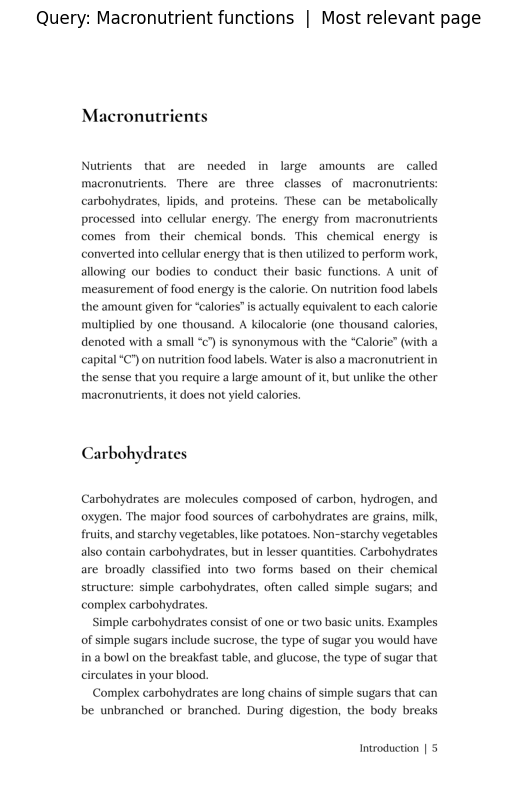

In [62]:
import fitz

pdf_path = "human-nutrition-text.pdf"

doc = fitz.open(pdf_path)
page = doc.load_page(5 + 41)

img = page.get_pixmap(dpi = 300)

doc.close()

# Convert the pixmap to a numpy array
img_array = np.frombuffer(img.samples_mv, dtype = np.uint8).reshape((img.h, img.w, img.n))

#display image using matplotlib
import matplotlib.pyplot as plt
plt.figure(figsize = (13, 10))
plt.imshow(img_array)
plt.title(f"Query: {query}  |  Most relevant page")
plt.axis("off")
plt.show()


## functionizing our semantic search pipeline

In [63]:
def retrieve_relevant_resources(query: str,
                                embeddings: torch.tensor,
                                model: SentenceTransformer = embedding_model,
                                n_resources_to_return: int = 5,
                                print_time: bool = True):
  """
  embeds a query with model and returns top k scores and indices from embeddings

  """

  # embed the query
  query_embedding = model.encode(query, convert_to_tensor = True)

  start_time = timer()
  dot_scores = util.dot_score(query_embedding, embeddings)[0]
  end_time = timer()

  if print_time:
    print(f"[INFO] Time taken to get scores on ({len(embeddings)} embeddings: {end_time - start_time: .5f} seconds")

  scores, indices = torch.topk(input = dot_scores,
                               k = n_resources_to_return)

  return scores, indices

def print_top_results_and_scores(query:str,
                                 embeddings: torch.tensor,
                                 pages_and_chunks: list[dict] = pages_and_chunks,
                                 n_resources_to_return: int = 5):
  """
  finds relevant passages given a query and prints them out along with their scores.
  """
  scores, indices = retrieve_relevant_resources(query = query,
                                                embeddings = embeddings,
                                                n_resources_to_return = n_resources_to_return)

  for score, idx in zip(scores, indices):
    print(f"Score: {score: .4f}")
    print_wrapped("Text:")
    print(pages_and_chunks[idx]["sentence_chunk"])
    print(f"Page number : {pages_and_chunks[idx]['page_number']}")
    print("\n")



In [64]:
query = "foods high in fiber"

print_top_results_and_scores(query = query, embeddings = embeddings)

[INFO] Time taken to get scores on (1680 embeddings:  0.00007 seconds
Score:  0.6964
Text:
• Change it up a bit and experience the taste and satisfaction of other whole grains such as barley, quinoa, and bulgur. • Eat snacks high in fiber, such as almonds, pistachios, raisins, and air-popped popcorn. Add an artichoke and green peas to your dinner plate more 276 | Carbohydrates and Personal Diet Choices
Page number : 276


Score:  0.6810
Text:
Dietary fiber is categorized as either water-soluble or insoluble. Some examples of soluble fibers are inulin, pectin, and guar gum and they are found in peas, beans, oats, barley, and rye. Cellulose and lignin are insoluble fibers and a few dietary sources of them are whole-grain foods, flax, cauliflower, and avocados. Cellulose is the most abundant fiber in plants, making up the cell walls and providing structure. Soluble fibers are more easily accessible to bacterial enzymes in the large intestine so they can be broken down to a greater extent 

## Getting an llm for local generation

we want to focus on local generation


In [65]:
import torch
gpu_memory_bytes = torch.cuda.get_device_properties(0).total_memory
gpu_memory_gb = round(gpu_memory_bytes / (2**30))
print(f"Available gpu memory: {gpu_memory_gb} gb")

Available gpu memory: 15 gb


In [105]:
# !pip install -i https://pypi.org/simple/ bitsandbytes
# !pip install accelerate

In [67]:
from huggingface_hub import login
login()

In [68]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers.utils import is_flash_attn_2_available

# 1. Create quantization config for smaller model loading (optional)
# Requires !pip install bitsandbytes accelerate, see: https://github.com/TimDettmers/bitsandbytes, https://huggingface.co/docs/accelerate/
# For models that require 4-bit quantization (use this if you have low GPU memory available)
from transformers import BitsAndBytesConfig
quantization_config = BitsAndBytesConfig(load_in_4bit=True,
                                         bnb_4bit_compute_dtype=torch.float16)

# Bonus: Setup Flash Attention 2 for faster inference, default to "sdpa" or "scaled dot product attention" if it's not available
# Flash Attention 2 requires NVIDIA GPU compute capability of 8.0 or above, see: https://developer.nvidia.com/cuda-gpus
# Requires !pip install flash-attn, see: https://github.com/Dao-AILab/flash-attention
if (is_flash_attn_2_available()) and (torch.cuda.get_device_capability(0)[0] >= 8):
  attn_implementation = "flash_attention_2"
else:
  attn_implementation = "sdpa"
print(f"[INFO] Using attention implementation: {attn_implementation}")

# 2. Pick a model we'd like to use (this will depend on how much GPU memory you have available)
model_id = "google/gemma-2b-it"
print(f"[INFO] Using model_id: {model_id}")

# 3. Instantiate tokenizer (tokenizer turns text into numbers ready for the model)
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=model_id)

# 4. Instantiate the model
llm_model = AutoModelForCausalLM.from_pretrained(pretrained_model_name_or_path=model_id,
                                                 torch_dtype=torch.float16, # datatype to use, we want float16
                                                 quantization_config=None,
                                                 low_cpu_mem_usage=False, # use full memory
                                                 attn_implementation=attn_implementation) # which attention version to use

if not quantization_config: # quantization takes care of device setting automatically, so if it's not used, send model to GPU
    llm_model.to("cuda")

[INFO] Using attention implementation: sdpa
[INFO] Using model_id: google/gemma-2b-it


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [69]:
llm_model

GemmaForCausalLM(
  (model): GemmaModel(
    (embed_tokens): Embedding(256000, 2048, padding_idx=0)
    (layers): ModuleList(
      (0-17): 18 x GemmaDecoderLayer(
        (self_attn): GemmaSdpaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=256, bias=False)
          (v_proj): Linear(in_features=2048, out_features=256, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): GemmaRotaryEmbedding()
        )
        (mlp): GemmaMLP(
          (gate_proj): Linear(in_features=2048, out_features=16384, bias=False)
          (up_proj): Linear(in_features=2048, out_features=16384, bias=False)
          (down_proj): Linear(in_features=16384, out_features=2048, bias=False)
          (act_fn): GELUActivation()
        )
        (input_layernorm): GemmaRMSNorm()
        (post_attention_layernorm): GemmaRMSNorm()
      )
    )
    (norm): GemmaRM

In [70]:
def get_model_num_params(model: torch.nn.Module):
    return sum([param.numel() for param in model.parameters()])

get_model_num_params(llm_model)

2506172416

In [71]:
def get_model_mem_size(model: torch.nn.Module):
    """
    Get how much memory a PyTorch model takes up.

    See: https://discuss.pytorch.org/t/gpu-memory-that-model-uses/56822
    """
    # Get model parameters and buffer sizes
    mem_params = sum([param.nelement() * param.element_size() for param in model.parameters()])
    mem_buffers = sum([buf.nelement() * buf.element_size() for buf in model.buffers()])

    # Calculate various model sizes
    model_mem_bytes = mem_params + mem_buffers # in bytes
    model_mem_mb = model_mem_bytes / (1024**2) # in megabytes
    model_mem_gb = model_mem_bytes / (1024**3) # in gigabytes

    return {"model_mem_bytes": model_mem_bytes,
            "model_mem_mb": round(model_mem_mb, 2),
            "model_mem_gb": round(model_mem_gb, 2)}

get_model_mem_size(llm_model)

{'model_mem_bytes': 5079453696, 'model_mem_mb': 4844.14, 'model_mem_gb': 4.73}

## Generating text from our LLM

In [72]:
input_text = "What are the macronutrients, and what roles do they play in the human body?"
print(f"Input text:\n{input_text}")

# Create prompt template for instruction-tuned model
dialogue_template = [
    {"role": "user",
     "content": input_text}
]

# Apply the chat template
prompt = tokenizer.apply_chat_template(conversation=dialogue_template,
                                       tokenize=False, # keep as raw text (not tokenized)
                                       add_generation_prompt=True)
print(f"\nPrompt (formatted):\n{prompt}")

Input text:
What are the macronutrients, and what roles do they play in the human body?

Prompt (formatted):
<bos><start_of_turn>user
What are the macronutrients, and what roles do they play in the human body?<end_of_turn>
<start_of_turn>model



In [73]:

llm_model.to("cuda")

GemmaForCausalLM(
  (model): GemmaModel(
    (embed_tokens): Embedding(256000, 2048, padding_idx=0)
    (layers): ModuleList(
      (0-17): 18 x GemmaDecoderLayer(
        (self_attn): GemmaSdpaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=256, bias=False)
          (v_proj): Linear(in_features=2048, out_features=256, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): GemmaRotaryEmbedding()
        )
        (mlp): GemmaMLP(
          (gate_proj): Linear(in_features=2048, out_features=16384, bias=False)
          (up_proj): Linear(in_features=2048, out_features=16384, bias=False)
          (down_proj): Linear(in_features=16384, out_features=2048, bias=False)
          (act_fn): GELUActivation()
        )
        (input_layernorm): GemmaRMSNorm()
        (post_attention_layernorm): GemmaRMSNorm()
      )
    )
    (norm): GemmaRM

In [74]:
%%time

#tokenzize the input text (turn it into numbers) and sent it to the gpu
input_ids = tokenizer(prompt,
                      return_tensors = "pt").to("cuda")


outputs = llm_model.generate(**input_ids,
                             max_new_tokens = 256)
print(f"Model Output (tokens): \n {outputs[0]} \n")

Model Output (tokens): 
 tensor([     2,      2,    106,   1645,    108,   1841,    708,    573, 186809,
        184592, 235269,    578,   1212,  16065,    749,    984,   1554,    575,
           573,   3515,   2971, 235336,    107,    108,    106,   2516,    108,
         21404, 235269,   1517, 235303, 235256,    476,  25497,    576,    573,
        186809, 184592,    578,   1024,  16065,    575,    573,   3515,   2971,
        235292,    109,    688,  12298,   1695, 184592,  66058,    109, 235287,
          5231, 156615,  56227,  66058,    108,    141, 235287,  34428,   4134,
           604,    573,   2971, 235303, 235256,   5999,    578,  29703, 235265,
           108,    141, 235287, 110165,  56227,    708,    573,   7920,   4303,
           576,   4134,    604,   1546,   5999, 235265,    108,    141, 235287,
         25280,  72780,    708,   1941,    674,   1987,   5543,    577,  55997,
        235269,   1582,    685,   3733,  29907, 235269,  16803, 235269,    578,
         19574,

In [75]:
#decoding outputs to text
outputs_decoded = tokenizer.decode(outputs[0])
print(f"Model output (decoded):\n{outputs_decoded}")

Model output (decoded):
<bos><bos><start_of_turn>user
What are the macronutrients, and what roles do they play in the human body?<end_of_turn>
<start_of_turn>model
Sure, here's a breakdown of the macronutrients and their roles in the human body:

**Macronutrients:**

* **Carbohydrates:**
    * Provide energy for the body's cells and tissues.
    * Carbohydrates are the primary source of energy for most cells.
    * Complex carbohydrates are those that take longer to digest, such as whole grains, fruits, and vegetables.
    * Simple carbohydrates are those that are quickly digested, such as sugar, starch, and lactose.

* **Proteins:**
    * Build and repair tissues, enzymes, and hormones.
    * Proteins are essential for immune function, hormone production, and tissue repair.
    * There are different types of proteins, each with specific functions.

* **Fats:**
    * Provide energy, insulation, and help absorb vitamins.
    * Healthy fats include olive oil, avocado, nuts, and seeds.
  

In [76]:
# Nutrition-style questions generated with GPT4
gpt4_questions = [
    "What are the macronutrients, and what roles do they play in the human body?",
    "How do vitamins and minerals differ in their roles and importance for health?",
    "Describe the process of digestion and absorption of nutrients in the human body.",
    "What role does fibre play in digestion? Name five fibre containing foods.",
    "Explain the concept of energy balance and its importance in weight management."
]

# Manually created question list
manual_questions = [
    "How often should infants be breastfed?",
    "What are symptoms of pellagra?",
    "How does saliva help with digestion?",
    "What is the RDI for protein per day?",
    "water soluble vitamins"
]

query_list = gpt4_questions + manual_questions

In [78]:
import random

query = random.choice(query_list)
print(f"Query : {query}")

# get just the scores and indices of top related results

scores, indices = retrieve_relevant_resources(query = query,
                                              embeddings = embeddings)

scores, indices


Query : What role does fibre play in digestion? Name five fibre containing foods.
[INFO] Time taken to get scores on (1680 embeddings:  0.00006 seconds


(tensor([0.5964, 0.5766, 0.5745, 0.5707, 0.5600], device='cuda:0'),
 tensor([1548,  360,  373,  380,  379], device='cuda:0'))

## Augmenting our prompt with context items

In [96]:
def prompt_formatter(query: str,
                     context_items: list[dict]) -> str:
    context = "- " + "\n- ".join([item["sentence_chunk"] for item in context_items])

    base_prompt = """Based on the following context items, please answer the query.
Give yourself room to think by extracting relevant passages from the context before answering the query.
Don't return the thinking, only return the answer.
Make sure your answers are as explanatory as possible.
Use the following examples as reference for the ideal answer style.
\nExample 1:
Query: What are the fat-soluble vitamins?
Answer: The fat-soluble vitamins include Vitamin A, Vitamin D, Vitamin E, and Vitamin K. These vitamins are absorbed along with fats in the diet and can be stored in the body's fatty tissue and liver for later use. Vitamin A is important for vision, immune function, and skin health. Vitamin D plays a critical role in calcium absorption and bone health. Vitamin E acts as an antioxidant, protecting cells from damage. Vitamin K is essential for blood clotting and bone metabolism.
\nExample 2:
Query: What are the causes of type 2 diabetes?
Answer: Type 2 diabetes is often associated with overnutrition, particularly the overconsumption of calories leading to obesity. Factors include a diet high in refined sugars and saturated fats, which can lead to insulin resistance, a condition where the body's cells do not respond effectively to insulin. Over time, the pancreas cannot produce enough insulin to manage blood sugar levels, resulting in type 2 diabetes. Additionally, excessive caloric intake without sufficient physical activity exacerbates the risk by promoting weight gain and fat accumulation, particularly around the abdomen, further contributing to insulin resistance.
\nExample 3:
Query: What is the importance of hydration for physical performance?
Answer: Hydration is crucial for physical performance because water plays key roles in maintaining blood volume, regulating body temperature, and ensuring the transport of nutrients and oxygen to cells. Adequate hydration is essential for optimal muscle function, endurance, and recovery. Dehydration can lead to decreased performance, fatigue, and increased risk of heat-related illnesses, such as heat stroke. Drinking sufficient water before, during, and after exercise helps ensure peak physical performance and recovery.
\nNow use the following context items to answer the user query:
{context}
\nRelevant passages: <extract relevant passages from the context here>
User query: {query}
Answer:"""
    base_prompt = base_prompt.format(context = context,
                                query = query)

    # create prompt template for instruction tuned model

    dialogue_template = [{"role" : "user",
                          "content" : base_prompt}]


    prompt = tokenizer.apply_chat_template(conversation=dialogue_template,
                                       tokenize=False, # keep as raw text (not tokenized)
                                       add_generation_prompt=True)
    return prompt

query = random.choice(query_list)
print(f"Query: {query}")

scores, indices = retrieve_relevant_resources(query = query,
                                              embeddings = embeddings)

context_items = [pages_and_chunks[i] for i in indices]

prompt = prompt_formatter(query = query,
                          context_items = context_items)


print(prompt)

Query: What role does fibre play in digestion? Name five fibre containing foods.
[INFO] Time taken to get scores on (1680 embeddings:  0.00009 seconds
<bos><start_of_turn>user
Based on the following context items, please answer the query.
Give yourself room to think by extracting relevant passages from the context before answering the query.
Don't return the thinking, only return the answer.
Make sure your answers are as explanatory as possible.
Use the following examples as reference for the ideal answer style.

Example 1:
Query: What are the fat-soluble vitamins?
Answer: The fat-soluble vitamins include Vitamin A, Vitamin D, Vitamin E, and Vitamin K. These vitamins are absorbed along with fats in the diet and can be stored in the body's fatty tissue and liver for later use. Vitamin A is important for vision, immune function, and skin health. Vitamin D plays a critical role in calcium absorption and bone health. Vitamin E acts as an antioxidant, protecting cells from damage. Vitamin K

In [97]:
input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")

# Generate an output of tokens
outputs = llm_model.generate(**input_ids,
                             temperature=0.7, # lower temperature = more deterministic outputs, higher temperature = more creative outputs
                             do_sample=True, # whether or not to use sampling, see https://huyenchip.com/2024/01/16/sampling.html for more
                             max_new_tokens=256) # how many new tokens to generate from prompt

# Turn the output tokens into text
output_text = tokenizer.decode(outputs[0])

print(f"Query: {query}")
print(f"RAG answer:\n{output_text.replace(prompt, '')}")

Query: What role does fibre play in digestion? Name five fibre containing foods.
RAG answer:
<bos>The relevant passage from the context is:

> "Dietary fiber is categorized as either water-soluble or insoluble. Some examples of soluble fibers are inulin, pectin, and guar gum and they are found in peas, beans, oats, barley, and rye. Cellulose and lignin are insoluble fibers and a few dietary sources of them are whole-grain foods, flax, cauliflower, and avocados. Cellulose is the most abundant fiber in plants, making up the cell walls and providing structure."<eos>


### Functionizing our llm answering feature

In [99]:
def ask(query,
        temperature=0.7,
        max_new_tokens=512,
        format_answer_text=True,
        return_answer_only=True):
    """
    Takes a query, finds relevant resources/context and generates an answer to the query based on the relevant resources.
    """

    # Get just the scores and indices of top related results
    scores, indices = retrieve_relevant_resources(query=query,
                                                  embeddings=embeddings)

    # Create a list of context items
    context_items = [pages_and_chunks[i] for i in indices]

    # Add score to context item
    for i, item in enumerate(context_items):
        item["score"] = scores[i].cpu() # return score back to CPU

    # Format the prompt with context items
    prompt = prompt_formatter(query=query,
                              context_items=context_items)

    # Tokenize the prompt
    input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")

    # Generate an output of tokens
    outputs = llm_model.generate(**input_ids,
                                 temperature=temperature,
                                 do_sample=True,
                                 max_new_tokens=max_new_tokens)

    # Turn the output tokens into text
    output_text = tokenizer.decode(outputs[0])

    if format_answer_text:
        # Replace special tokens and unnecessary help message
        output_text = output_text.replace(prompt, "").replace("<bos>", "").replace("<eos>", "").replace("Sure, here is the answer to the user query:\n\n", "")

    # Only return the answer without the context items
    if return_answer_only:
        return output_text

    return output_text, context_items

In [103]:
query = random.choice(query_list)
print(f"Query: {query}")

# Answer query with context and return context
answer, context_items = ask(query=query,
                            temperature=0.7,
                            max_new_tokens=512,
                            return_answer_only=False)

print(f"Answer:\n")

print_wrapped(answer)


Query: Explain the concept of energy balance and its importance in weight management.
[INFO] Time taken to get scores on (1680 embeddings:  0.00007 seconds
Answer:

Sure, here's an explanation of energy balance and its importance in weight
management:  **Energy balance** refers to the dynamic balance between energy
intake and expenditure in the body. This balance is crucial for maintaining body
weight and overall health. When you have a positive energy balance, your body
uses energy for various functions, including muscle function, tissue repair, and
maintenance. Conversely, when you have a negative energy balance, your body
relies more heavily on stored energy sources, which can lead to weight gain and
obesity.  In this context, the passage suggests that:  * **Energy balance is
achieved when intake of energy is equal to energy expended.** This means that
the body can maintain its current weight and energy level. * **Factors such as
genetics, lifestyle choices, and mental health can af